# Purpose

This notebook works through an example workflow using [hyperopt](http://hyperopt.github.io/hyperopt/) to tune a Keras model, while tracking the results with MLFlow.

# Data

The CA housing data will be used for this example, which is a simple regressiont task. It will be loaded from the `sklearn` data loader.  I'll split off 20% into a test set and an additional 20% into a validation set.  Finally, I'll standardize the data using `StandardScaler` ahead of modeling.

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, test_size=0.2
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

pd.DataFrame(X_train, columns=housing.feature_names).describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04,1.320900e+04
mean,-8.609730e-15,1.325981e-16,-3.962342e-15,-5.891335e-15,7.853679e-17,6.024740e-17,5.788053e-16,1.875900e-13
std,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00,1.000038e+00
min,-1.765977e+00,-2.192404e+00,-1.845222e+00,-1.557108e+00,-1.216098e+00,-1.900291e-01,-1.445563e+00,-2.402163e+00
25%,-6.853710e-01,-8.377356e-01,-4.057340e-01,-1.860147e-01,-5.480511e-01,-5.372921e-02,-7.926102e-01,-1.110003e+00
50%,-1.788677e-01,3.881461e-02,-8.074580e-02,-9.858909e-02,-2.221328e-01,-2.317569e-02,-6.422903e-01,5.327435e-01
75%,4.564668e-01,6.763056e-01,2.536591e-01,5.452616e-03,2.454150e-01,1.209641e-02,9.783469e-01,7.781538e-01
max,5.803226e+00,1.871601e+00,5.157842e+01,6.723061e+01,2.922314e+01,9.689713e+01,2.974784e+00,2.546109e+00


In [2]:
train_data = (X_train, {"main_output": y_train, "aux_output": y_train})
val_data = (X_valid, {"main_output": y_valid, "aux_output": y_valid})

# Model

The model used for this example will be a wide and deep network with the following characteristics:
- a deep path with `n_hidden` hidden layers with `n_neurons` at each layer
- a wide path connecting all inputs to the output
- all layers are fully connected
- two outpus:
    - one from the deep path alone, fit to the target
    - one from the concatenaded wide and deep paths, fit to the target

This type of multi-output architecture is usually used as a regularization technique, but I'm simply employing it here so my example has more than one loss to simultaneously minimize.  This model is very similar to the regression example I used in my [intro to Keras](https://github.com/mcnewcp/book-geron-ml-sklearn-keras-tensorflow/blob/main/10-intro-ann-keras/10-intro-ann-keras.ipynb) notebook and from Chapter 10 of [Hands on ML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), so I won't explain the Keras code below.

The model build code should be functionalized so that the hyperparameters are generalized in the build and compile steps for integration into hyperparameter tuning.  I'm pulling out the following hyperparameters for tuning:
- `n_hidden`: number of hidden layers
- `n_neurons`: number of neurons per layer
- `activation`: activation funciton used in hidden layers

*Note*: I'm not tuning learning rate here.  In general I think it's best practice to choose a sufficiently low learning rate, high number of epochs, and use early stopping.  The goal of this stage of hyperparameter tuning is to simply identify promising model candidates.  Once promising candidates have been identified, the learning rate will be fine tuned.

In [3]:
import tensorflow as tf
from tensorflow import keras

print("tf version:", tf.__version__, ", keras version:", keras.__version__)



2023-02-16 19:40:01.069286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf version: 2.11.0 , keras version: 2.11.0


In [4]:
def build_model(n_hidden=1, n_neurons=20, activation="relu"):
    inp = keras.layers.Input(shape=[8], name="input")  # input layer
    for layer in range(n_hidden):  # sequentially add hidden layers
        if layer == 0:
            hl = keras.layers.Dense(n_neurons, activation=activation)(inp)
        else:
            hl = keras.layers.Dense(n_neurons, activation=activation)(hl)
    concat = keras.layers.Concatenate()([hl, inp])  # concat deep and wide paths
    main_output = keras.layers.Dense(1, name="main_output")(concat)  # combined output
    aux_output = keras.layers.Dense(1, name="aux_output")(hl)  # deep output
    model = keras.Model(inputs=[inp], outputs=[main_output, aux_output])
    model.compile(
        loss={"main_output": "mse", "aux_output": "mse"},
        loss_weights={
            "main_output": 0.9,
            "aux_output": 0.1,
        },  # weighting heavily towards main output
        optimizer=keras.optimizers.SGD(learning_rate=1e-3),
    )
    return model

# Hyperopt with Validation Split

[Hyperopt](http://hyperopt.github.io/hyperopt/) is an optimization library commonly used to tune hyperparameters during model experimentation, though it is an entirely general package.  It will search through an arbitrarily complex search space to minimize and objective function.  The steps of using hyperopt include:
1. define objective function
2. define search space
3. run the minimization

## Objective Function

Hyperopt works by changing values in your hyperparameter space and evaluating the objective function to receive a score (`loss`).  It then investigates promising areas of the search space more thoroughly.  The objective function should take in the chosen values of hyperparameters and output a loss for minimization and a status.  It can also output anything else you'd like to log in the trials object, but I won't include anything else here.

In [5]:
from utils import fit_eval_log
from hyperopt import STATUS_OK

def objective(hyper_params):
    model = build_model(**hyper_params)
    run_name = "test-hp"
    mean_val_loss = fit_eval_log(
        run_name=run_name,
        train_data=train_data,
        val_data=val_data,
        model=model,
        hyper_params=hyper_params,
    )
    return {"loss": mean_val_loss, "status": STATUS_OK}


## Search Space

The hyperparameter search space needs to be set up in a way to inform hyperopt not only the bounds of the hyperparameters but also how to choose values in between the bounds.  This is done by using the most relevant parameter expression from `hyperopt.hp`.  The [documentation](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/) lists all options, but the most relevant in my experience are:
- `hp.choice()` chooses an option from a supplied list
- `hp.uniform()` samples a continuous value between a lower and upper bound
- `hp.quniform()` samples an integer between a lower and upper bound

*Note*: there is an uresolved type issue around using `hp.quniform()` which is resolved by wrapping it in `scope.int()` from `hyperopt.pyll`.

Below, I'll set up the search space for my example which includes number of neurons per layer, number of hidden layers, and activation function.

In [6]:
from hyperopt import hp
from hyperopt.pyll import scope

hyper_params = {
    "n_hidden": scope.int(hp.quniform("n_hidden", 1, 10, 1)),
    "n_neurons": scope.int(hp.quniform("n_neurons", 3, 50, 1)),
    "activation": hp.choice("activation", ["relu", "sigmoid", "tanh"]),
}


## Minimize Objective

Now to run the optimization, I'll use `fmin()` and ask hyperopt to suggest the best optimization algorithm with `tpe.suggest`.  You simply supply the objective function along with the search space and tell hyperopt how many trials you want to run, then it'll return the best trial along with a history of the trials in a `Trials()` object.

In [7]:
from hyperopt import Trials, fmin, tpe
import mlflow

mlflow.set_experiment(experiment_name='test-hp')
mlflow.tensorflow.autolog(silent=True)

trials = Trials()
best = fmin(
    fn=objective,
    space=hyper_params,
    algo=tpe.suggest,
    max_evals=10,
    trials=trials,
    verbose=1,
)


  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

2023-02-16 19:40:13.343605: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 121ms/step 

  0%|          | 0/10 [00:17<?, ?trial/s, best loss=?]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpa46k49z7/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpa46k49z7/model/data/model/assets



1/1 [==============================] - 0s 64ms/step                             

 10%|█         | 1/10 [00:41<04:03, 27.03s/trial, best loss: 0.42732077836990356]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpyenxje34/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpyenxje34/model/data/model/assets



1/1 [==============================] - 0s 110ms/step                            

 20%|██        | 2/10 [01:06<03:17, 24.67s/trial, best loss: 0.42732077836990356]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpu7en3q0r/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpu7en3q0r/model/data/model/assets



1/1 [==============================] - 0s 110ms/step                            

 30%|███       | 3/10 [01:33<02:57, 25.33s/trial, best loss: 0.41186773777008057]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpyp51ukbw/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpyp51ukbw/model/data/model/assets



 40%|████      | 4/10 [01:44<02:37, 26.32s/trial, best loss: 0.41186773777008057]WARNING:tensorflow:5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f82e25fddc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 108ms/step                            

 40%|████      | 4/10 [02:08<02:37, 26.32s/trial, best loss: 0.41186773777008057]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmp8ol7_oc0/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmp8ol7_oc0/model/data/model/assets



 50%|█████     | 5/10 [02:22<02:32, 30.53s/trial, best loss: 0.41186773777008057]WARNING:tensorflow:6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f82e3f1cd30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 111ms/step                            

 50%|█████     | 5/10 [02:42<02:32, 30.53s/trial, best loss: 0.41186773777008057]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmp4m6kpw1t/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmp4m6kpw1t/model/data/model/assets



1/1 [==============================] - 0s 59ms/step                             

 60%|██████    | 6/10 [03:08<02:04, 31.04s/trial, best loss: 0.41186773777008057]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmp5mw8zcrg/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmp5mw8zcrg/model/data/model/assets



1/1 [==============================] - 0s 119ms/step                            

 70%|███████   | 7/10 [03:52<01:26, 28.92s/trial, best loss: 0.41186773777008057]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpi48q0ww3/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpi48q0ww3/model/data/model/assets



1/1 [==============================] - 0s 85ms/step                             

 80%|████████  | 8/10 [04:32<01:09, 34.69s/trial, best loss: 0.41186773777008057]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmp5g5w4ruw/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmp5g5w4ruw/model/data/model/assets



1/1 [==============================] - 0s 129ms/step                            

 90%|█████████ | 9/10 [05:17<00:36, 36.12s/trial, best loss: 0.41186773777008057]

INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpm01t9x7e/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/tmpm01t9x7e/model/data/model/assets



100%|██████████| 10/10 [05:31<00:00, 33.14s/trial, best loss: 0.41186773777008057]


## Evaluate Results

The object returned by optimizationa above contains the best combination of hyperparameters.  To get them in the same form as our hyperparameter dictionary used in `build_model()` I'll use `space_eval()`.  I can then use them to build the best model and train on the full training set if I like.

The `trials` object returned by the optimization run is a log of all the trials, including all of the associated hyperparameters, losses, statuses, and any other values we decided to pass from the objective function.  This object can be pickled and saved if desired.  I don't usually do this, especially if my runs are already logged in mlflow, but I'll show how below. One thing I do like to do, however, is plot a time series of the losses so I can see how efficiently the optimization ran and whether or not I can safely trim some evaluations off of `max_evals` for the next experiment.

In [11]:
from hyperopt import space_eval

# find best parameters
best_params = space_eval(hyper_params, best)
print(f"best hyperparameters: {best_params}")

# build best model
best_mod = build_model(**best_params)


best hyperparameters: {'activation': 'tanh', 'n_hidden': 7, 'n_neurons': 24}


In [12]:
import pickle

# save trials object
pickle.dump(trials, open("./hp-trials/test-trial.p", "wb"))

# to load
# check = pickle.load(open('./hp-trials/test-trial.p', 'rb'))


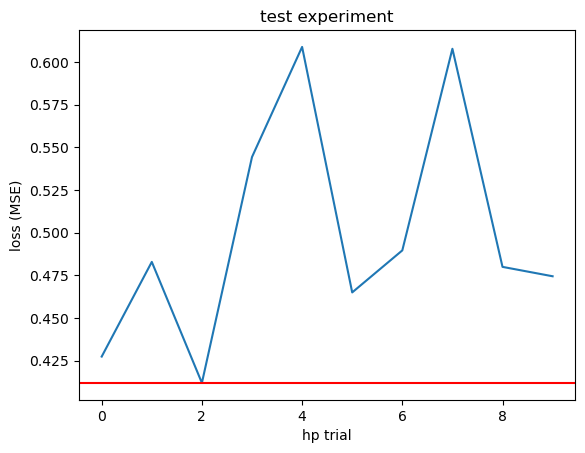

In [13]:
import matplotlib.pyplot as plt

# plot time series of validation losses
losses = [r["loss"] for r in trials.results]
plt.plot(losses)
plt.axhline(min(losses), c="r")

plt.title("test experiment")
plt.xlabel("hp trial")
plt.ylabel("loss (MSE)")
plt.show()


In [ ]:
trials.losses()